In [1]:
import numpy as np
import os
import torch
from torch.utils.data import Dataset, DataLoader
import glob
from tqdm import tqdm
from dataset import create_datasets
from baseline_model import MarineMammalInceptionNet
from evaluation import evaluate_ensemble, plot_calibration_curve

## Load dataset and initialize model. Use seed=42 to split train/test

Scanning directories...


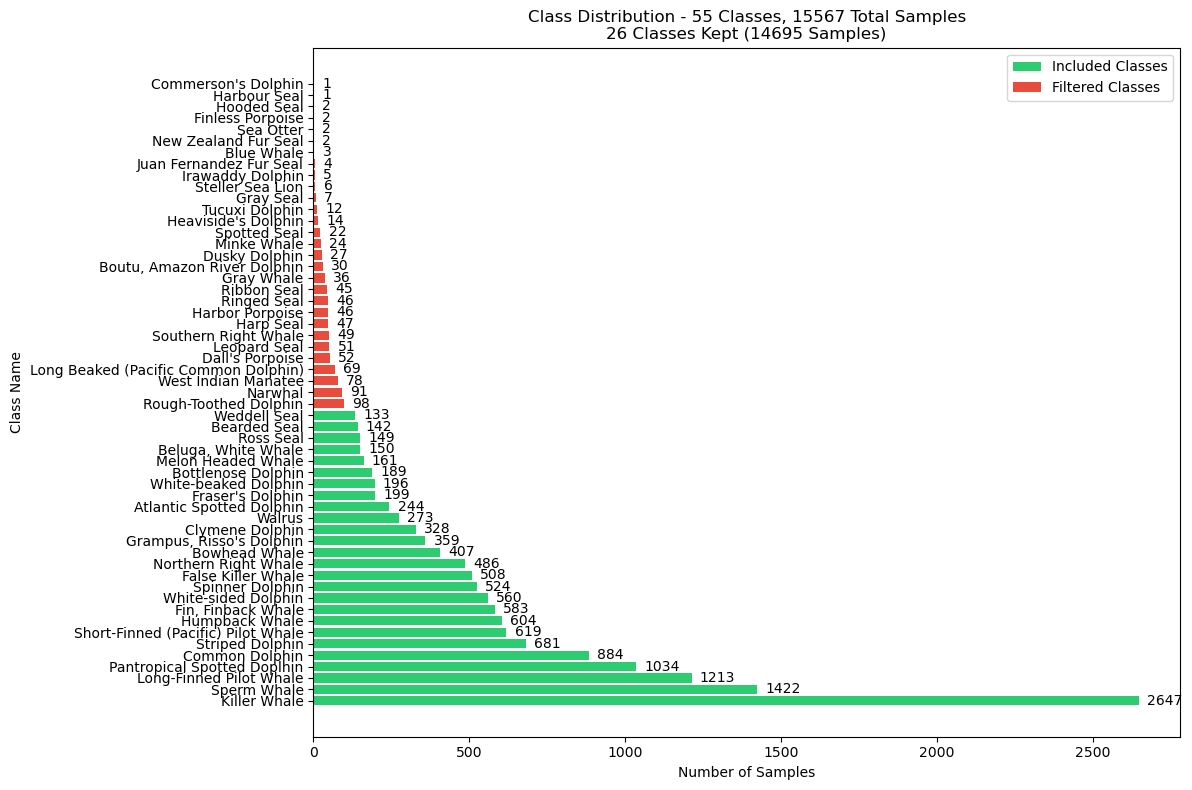

<Figure size 1200x1650 with 0 Axes>

Dataset Summary:
  - Total classes: 55
  - Classes meeting min_samples threshold: 26
  - Total samples: 15567
  - Kept samples: 14695 (94.4%)
  - Min samples per class: 1
  - Max samples per class: 2647
  - Avg samples per class: 283.0
Class distribution in split:
  - Atlantic Spotted Dolphin: Train 195/244 (79.9%), Test 49/244 (20.1%)
  - Bearded Seal: Train 114/142 (80.3%), Test 28/142 (19.7%)
  - Beluga, White Whale: Train 120/150 (80.0%), Test 30/150 (20.0%)
  - Bottlenose Dolphin: Train 151/189 (79.9%), Test 38/189 (20.1%)
  - Bowhead Whale: Train 326/407 (80.1%), Test 81/407 (19.9%)
  - Clymene Dolphin: Train 262/328 (79.9%), Test 66/328 (20.1%)
  - Common Dolphin: Train 707/884 (80.0%), Test 177/884 (20.0%)
  - False Killer Whale: Train 407/508 (80.1%), Test 101/508 (19.9%)
  - Fin, Finback Whale: Train 466/583 (79.9%), Test 117/583 (20.1%)
  - Fraser's Dolphin: Train 159/199 (79.9%), Test 40/199 (20.1%)
  - Grampus, Risso's Dolphin: Train 287/359 (79.9%), Test 72/359 (20.1%)
  

100%|██████████| 11756/11756 [02:46<00:00, 70.41it/s]


Computing normalization parameters...
Normalization parameters:
  - Mean: tensor([4.3521])
  - Std: tensor([17.7221])
Loading 2939 tensors into memory...


100%|██████████| 2939/2939 [00:41<00:00, 71.03it/s]


In [2]:
root_dir = "data/preprocessed"
split_seed = 42
# Keep only labels with at least 100 examples
train_dataset, test_dataset, class_to_idx = create_datasets(
    root_dir=root_dir,
    test_size=0.2,
    min_samples=100,
    random_state=split_seed
)

class_weights = train_dataset.get_class_weights()
num_classes = len(class_to_idx)

In [3]:
# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=3072, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=3072, shuffle=False, num_workers=4)

## Training with ensemble of 5 models

In [4]:
# Example training setup
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR

import time
import torch
import datetime

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_models = 5
state_dict_files = []


for model_num in range(num_models):
    model = MarineMammalInceptionNet(num_classes)
    model = model.to(device)

    num_epochs = 3000

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
    optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)

    # Calculate total steps for the scheduler
    total_steps = len(train_loader) * num_epochs

    # Define the learning rate scheduler
    scheduler = OneCycleLR(
        optimizer,
        max_lr=0.01,  # Maximum learning rate at the peak of the cycle
        total_steps=total_steps,
        pct_start=0.3,  # Percentage of steps spent in the increasing phase
        anneal_strategy='cos',  # Cosine annealing for decreasing phase
        div_factor=25.0,  # Initial learning rate = max_lr/div_factor
        final_div_factor=1000.0  # Final learning rate = initial_lr/final_div_factor
    )
    
    

    # Training loop with time and GPU memory tracking
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start = time.time()
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Step the scheduler (OneCycleLR is updated per batch)
            scheduler.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        epoch_time = time.time() - epoch_start

        # Get GPU memory usage
        gpu_memory_used = 0
        if torch.cuda.is_available():
            # Get current GPU memory usage in MB
            gpu_memory_used = torch.cuda.max_memory_allocated() / (1024 ** 2)
            # Reset peak memory stats for next epoch
            torch.cuda.reset_peak_memory_stats()

        # Get current learning rate
        current_lr = scheduler.get_last_lr()[0]

        # Format time as hours:minutes:seconds
        epoch_time_str = str(datetime.timedelta(seconds=int(epoch_time)))
        total_time_str = str(datetime.timedelta(seconds=int(time.time() - start_time)))

        print(f'Model {model_num} Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, LR: {current_lr:.6f}, Time: {epoch_time_str}, GPU Memory: {gpu_memory_used:.1f} MB, Total Time: {total_time_str}')

    # Report final training statistics
    total_training_time = time.time() - start_time
    print(f'Finished Training model {model_num} in {str(datetime.timedelta(seconds=int(total_training_time)))}')
    checkpoint_filename = f"checkpoints/ensemble_model_{model_num}.pth"
    torch.save(model.state_dict(), checkpoint_filename)
    state_dict_files.append(checkpoint_filename)

Model 0 Epoch 1/3000, Loss: 3.1986, LR: 0.000400, Time: 0:00:03, GPU Memory: 11109.6 MB, Total Time: 0:00:03
Model 0 Epoch 2/3000, Loss: 3.0325, LR: 0.000400, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:04
Model 0 Epoch 3/3000, Loss: 2.8920, LR: 0.000400, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:05
Model 0 Epoch 4/3000, Loss: 2.7510, LR: 0.000400, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:06
Model 0 Epoch 5/3000, Loss: 2.6053, LR: 0.000401, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:08
Model 0 Epoch 6/3000, Loss: 2.4528, LR: 0.000401, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:09
Model 0 Epoch 7/3000, Loss: 2.3007, LR: 0.000401, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:10
Model 0 Epoch 8/3000, Loss: 2.1633, LR: 0.000402, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:11
Model 0 Epoch 9/3000, Loss: 2.0344, LR: 0.000402, Time: 0:00:01, GPU Memory: 11109.6 MB, Total Time: 0:00:12
Model 0 Epoch 10/30

## Inference and evaluation

In [9]:
print("Evaluating on training set...")
train_metrics = evaluate_ensemble(model, state_dict_files, train_loader, device)
# Evaluate on test set
print("\nEvaluating on test set...")
test_metrics = evaluate_ensemble(model, state_dict_files, test_loader, device)

# Print metrics
print("\n===== Training Set Metrics =====")
print(f"Accuracy: {train_metrics['accuracy']:.4f}")
print(f"Precision: {train_metrics['precision']:.4f}")
print(f"Recall: {train_metrics['recall']:.4f}")
print(f"F1 Score: {train_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {train_metrics['ece']:.4f}")
print(f"Mean Predictive Entropy: {train_metrics['mean_predictive_entropy']:.4f}")
print(f"Mean Mutual Information: {train_metrics['mean_mutual_information']:.4f}")
print(f"Mean Probability Variance: {train_metrics['mean_prob_variance']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(train_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {train_metrics['inference_time_per_sample']*1000:.2f} ms")

print("\n===== Test Set Metrics =====")
print(f"Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1']:.4f}")
print(f"Expected Calibration Error: {test_metrics['ece']:.4f}")
print(f"Mean Predictive Entropy: {test_metrics['mean_predictive_entropy']:.4f}")
print(f"Mean Mutual Information: {test_metrics['mean_mutual_information']:.4f}")
print(f"Mean Probability Variance: {test_metrics['mean_prob_variance']:.4f}")
print(f"Inference Time: {str(datetime.timedelta(seconds=int(test_metrics['inference_time'])))}")
print(f"Inference Time per Sample: {test_metrics['inference_time_per_sample']*1000:.2f} ms")

Evaluating on training set...

Evaluating on test set...

===== Training Set Metrics =====
Accuracy: 0.9844
Precision: 0.9864
Recall: 0.9844
F1 Score: 0.9845
Expected Calibration Error: 0.0049
Mean Predictive Entropy: 0.0216
Mean Mutual Information: 0.0003
Mean Probability Variance: 0.0000
Inference Time: 0:00:01
Inference Time per Sample: 0.16 ms

===== Test Set Metrics =====
Accuracy: 0.8782
Precision: 0.8765
Recall: 0.8782
F1 Score: 0.8765
Expected Calibration Error: 0.0588
Mean Predictive Entropy: 0.2805
Mean Mutual Information: 0.1762
Mean Probability Variance: 0.0036
Inference Time: 0:00:00
Inference Time per Sample: 0.23 ms


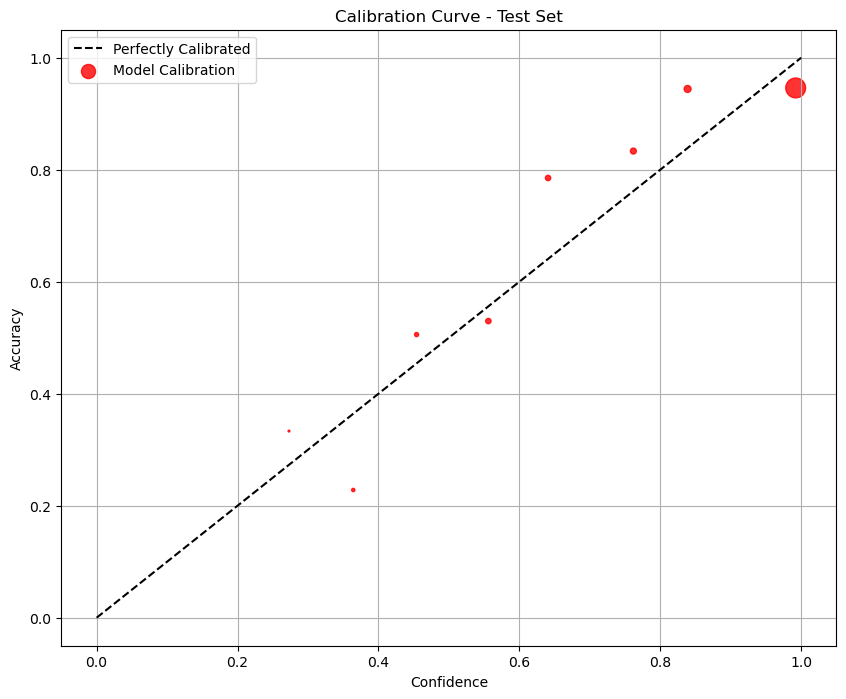

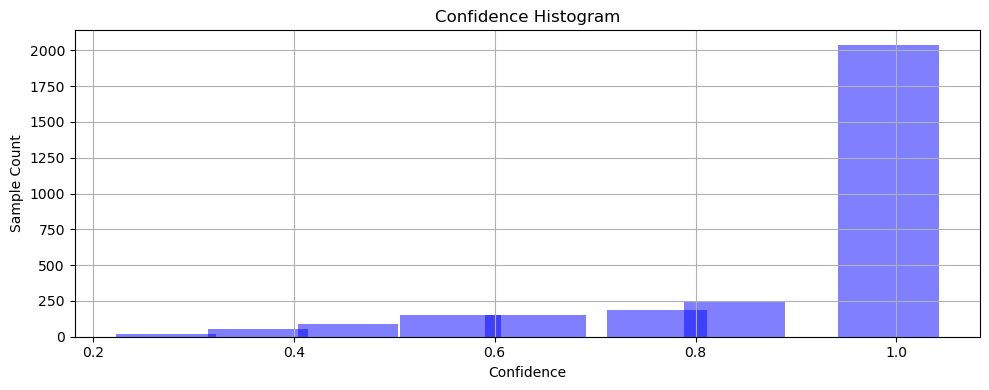

In [10]:
# Plot calibration curve for test set
plot_calibration_curve(
    test_metrics['bin_accuracies'], 
    test_metrics['bin_confidences'], 
    test_metrics['bin_counts'],
    'Calibration Curve - Test Set'
)